## Analysis of bilingual children's word use frequency
This notebook contains the code to identify the top 5 words used in aggregate by children in the [Corpus of bilingual children's speech](https://www.kaggle.com/rtatman/corpus-of-bilingual-childrens-speech) and relate the use of these five words to age. <br>
Sections:
1. [Transcript processing & word extraction](#preprocessing)
2. [Identifying the 5 most used words](#top5words)
3. [Word use frequency by child](#wordsbychild)
4. [Word use as proportion of all words by child](#wordpropbychild)
5. [Exploratory analysis: word clouds by age tertile](#wordclouds)

In [2]:
## load libraries
library(ggplot2) # plotting
library(tidyverse) # data wrangling
library(tidytext) # text analysis
library(MetBrewer) # color palettes
library(car) # anova wrapper
library(effectsize) # effect size estimates

### Transcript processing & word extraction <a name="preprocessing"></a>
First, we want to loop over the transcripts and extract each word spoken by each child. The basic 'unnest_tokens' function already removes punctuation, but within the loop, we also remove responses coded with '0' (no response), and 'xxx' (unintelligible speech). 

In [4]:
# get data summary & child demographics
data_guide <- read.csv('archive/guide_to_files.csv')
# remove spaces in the file_name column to avoid merging errors later
data_guide$file_name <- gsub(" ", "", data_guide$file_name)

In [5]:
# get list of all files
file_list <- list.files(path="archive", pattern="*.cha", full.names=T)

# initialize empty list to save individual words per child
word_list <- list()

# loop over files
for (i in 1:length(file_list)){
     
  # extract only file name 
  file_name <- gsub("archive/", "", file_list[i])
  
  file_text <- readLines(file_list[i])
  child_speech <- as.data.frame(file_text[grep("\\*CHI:",file_text)])
    
  # give temporary column name to enable splitting
  colnames(child_speech) <- c('temp')
  
  # split into columns to make tidytext analysis cleaner
  # split on 'HI:' instead of ':' only to avoid losing any content
  # rename first column as 'file_name'
  # this will enable us to bind the word count information with demographics
  child_speech <- separate(data = child_speech, col = temp, into = c("file_name", "content"), sep = "HI:")
  child_speech$file_name <- file_name
  
  # get all tokens (= words)
  child_words <- child_speech %>% 
    unnest_tokens(word, content)
  
  # the unnest_tokens command has already filtered out punctuation 
  # e.g. (.) pauses and <> overlapped speech  
  # but we also want to filter out 0 (no response)
  # and xxx (presumably, muddled speech?)
  child_words_filtered <- filter(child_words, word != 'xxx' & word != 0)
  
  # now save the full dataframe to the list
  word_list[[i]] <- child_words_filtered
  
}

### Identifying the five most used words <a name="top5words"></a>
We have now processed the transcripts and extracted each individual word. We now want to summarize this dataset and find the 5 most used words in aggregate.

In [9]:
# combine word list & extract top 5 words *in aggregate* across all kids
top_five_overall <- bind_rows(word_list) %>%
  count(word, sort = T) %>%
  head(.,5)

# look at top five words
top_five_overall

word,n
<chr>,<int>
i,3177
yeah,2261
and,1924
a,1204
the,1123


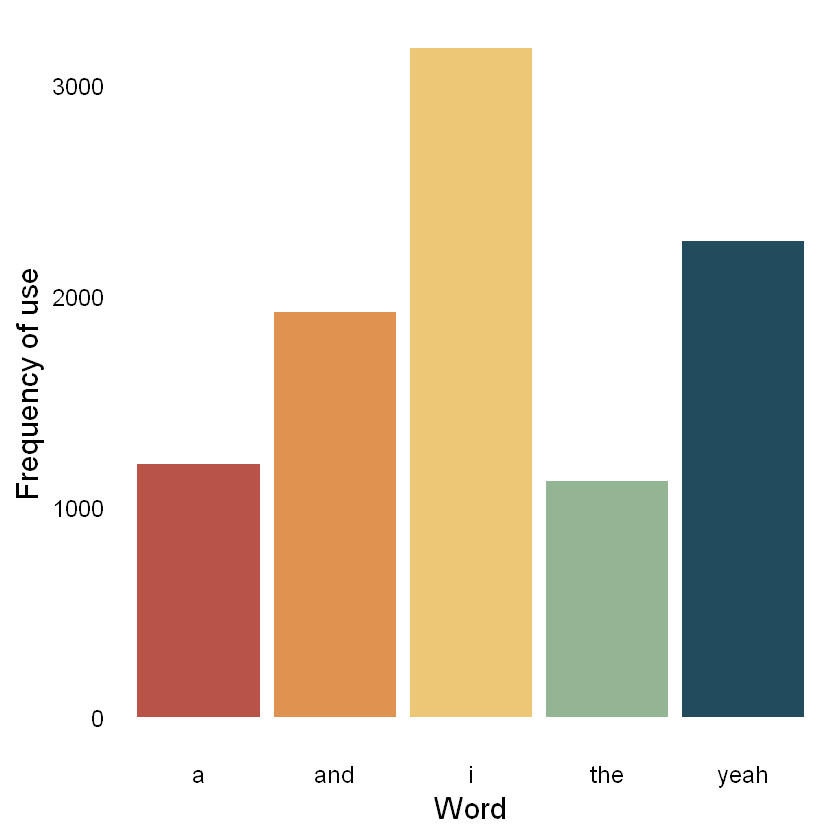

In [140]:
# bar plot of word use frequency
ggplot(data = top_five_overall, aes(x = word, y = n)) +
  geom_bar(stat = 'identity', aes(fill = word)) +
  scale_fill_manual(values=met.brewer("Hokusai1")[c(2,4:7)]) +
  theme_minimal(base_size = 18) +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.text.x=element_text(colour="black"),
        axis.text.y=element_text(colour="black"),
        legend.position="none") +
  xlab('Word') + ylab('Frequency of use')

### Word use frequency by child <a name="wordsbychild"></a>
We now know the top 5 most used words. Now, we want to figure out the number of times each child used each word in their interview. To do this, we will first isolate only the top 5 words in aggregate in each child's data, and then append their ages to the dataset.

In [32]:
# count unique words per child
child_word_count_all <- bind_rows(word_list) %>%
  group_by(file_name) %>%
  count(word)

# keep only counts of the aggregate top 5 words
top_five_by_child = merge(child_word_count_all, top_five_overall, by='word')

# rename columns to make them more intuitive
colnames(top_five_by_child) <- c('word','file_name','count_child','count_overall')

# remove spaces to fix merging issues that appeared later on
top_five_by_child$file_name <- gsub(" ", "", top_five_by_child$file_name)

# combine with data guide: append kids' ages
# keep only the data guide columns we care about
data_guide_short <- data_guide %>%
  select(file_name, age_at_recording_months)

# now merge with word data
top_five_by_child <- merge(data_guide_short,top_five_by_child, by='file_name')

top_five_by_child$file_name <- as.factor(top_five_by_child$file_name)

The dataframe 'top_five_by_child' contains the number of times each child used each of the 5 most used words. We can now plot these data, split by word.

`geom_smooth()` using formula 'y ~ x'



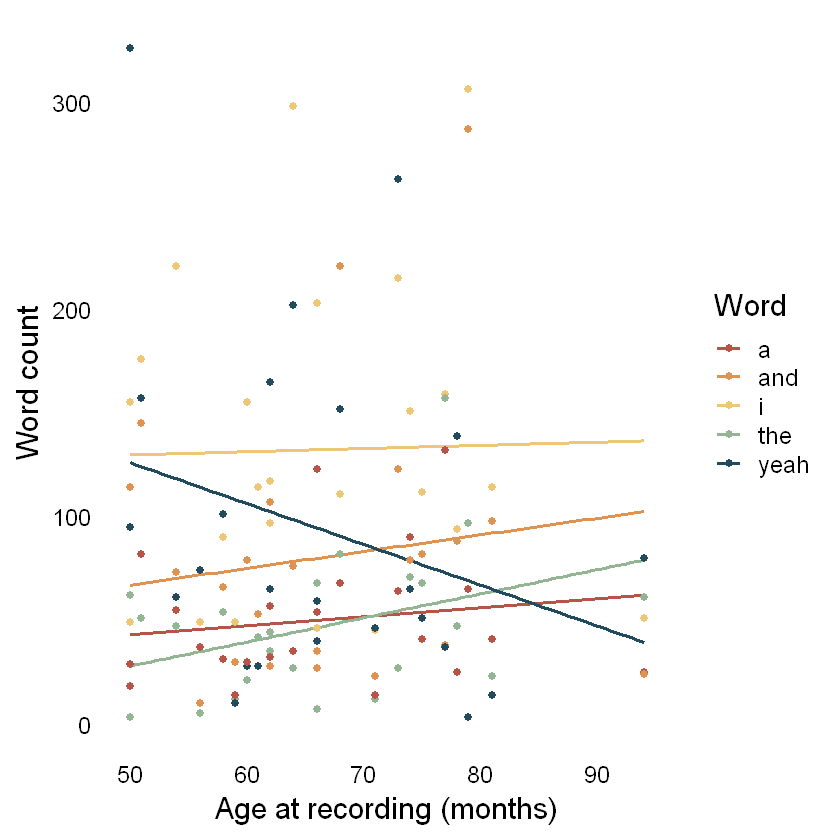

In [143]:
# for plotting
top_five_by_child$Word <- as.factor(top_five_by_child$word)

# plot against age
ggplot(data = top_five_by_child, aes(x = age_at_recording_months, y = count_child, color = Word)) +
  geom_smooth(aes(group = Word, color = Word), method = 'lm', se = F) +
  geom_point(size = 2) + 
  scale_color_manual(values=met.brewer("Hokusai1")[c(2,4:7)]) +
  theme_minimal(base_size = 18) +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.text.x=element_text(colour="black"),
        axis.text.y=element_text(colour="black")) +
  xlab('Age at recording (months)') + ylab('Word count')

We can now enter all of the data into a single omnibus ANOVA. This analysis tells us whether there is a general trend for some words to be used more or less, and whether there is an interaction between age and word use.


Error: file_name
                        Df Sum Sq Mean Sq F value Pr(>F)
age_at_recording_months  1    195     195   0.026  0.873
Residuals               22 162503    7387               

Error: file_name:word
                             Df Sum Sq Mean Sq F value   Pr(>F)    
word                          4 118443   29611  10.286 7.02e-07 ***
word:age_at_recording_months  4  17208    4302   1.494    0.211    
Residuals                    88 253328    2879                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

We find a significant main effect of word, meaning that some words are consistently used more than others. However, there is no significant interaction between age and word use.
While the interaction in the ANOVA was not significant, we are still interested in the relationship between age and each of the words. We can run a series of correlations to determine whether the use of each of these words is significantly related to age, and use a Bonferroni correction for multiple comparisons (i.e., alpha level equals 0.05 / 5 = .01).

In [41]:
# simple correlations
# first, switch from long to wide

#top_five_by_child
top_five_wide <- reshape(top_five_by_child, idvar = c("file_name","age_at_recording_months"), timevar = "word", direction = "wide")

# correlations
# word: i
cor.test(top_five_wide$age_at_recording_months, top_five_wide$count_child.i)

# word: a
cor.test(top_five_wide$age_at_recording_months, top_five_wide$count_child.a)

# word: and
cor.test(top_five_wide$age_at_recording_months, top_five_wide$count_child.and)

# word: the
cor.test(top_five_wide$age_at_recording_months, top_five_wide$count_child.the)

# word: yeah
cor.test(top_five_wide$age_at_recording_months, top_five_wide$count_child.yeah)


	Pearson's product-moment correlation

data:  top_five_wide$age_at_recording_months and top_five_wide$count_child.i
t = 0.10664, df = 22, p-value = 0.916
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3841904  0.4222540
sample estimates:
       cor 
0.02272885 



	Pearson's product-moment correlation

data:  top_five_wide$age_at_recording_months and top_five_wide$count_child.a
t = 0.72804, df = 22, p-value = 0.4743
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2665053  0.5243353
sample estimates:
     cor 
0.153381 



	Pearson's product-moment correlation

data:  top_five_wide$age_at_recording_months and top_five_wide$count_child.and
t = 0.64827, df = 22, p-value = 0.5235
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2820647  0.5120281
sample estimates:
      cor 
0.1369102 



	Pearson's product-moment correlation

data:  top_five_wide$age_at_recording_months and top_five_wide$count_child.the
t = 1.8873, df = 22, p-value = 0.07238
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03544602  0.67503587
sample estimates:
      cor 
0.3732883 



	Pearson's product-moment correlation

data:  top_five_wide$age_at_recording_months and top_five_wide$count_child.yeah
t = -1.3068, df = 22, p-value = 0.2048
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6061608  0.1513959
sample estimates:
       cor 
-0.2683922 


### Word use as proportion of all words by child <a name="wordpropbychild"></a>
The data above suggest that the word use frequency changes somewhat with age, but not significantly so. One possible confound we should explore is the <i>total</i> number of words spoken by children of different ages. To address this, we can instead represent each of the five words as the proportion of the <i>total</i> number of words spoken. This would account for any potential differences in how prominent each word is in each child's vocabulary and how verbose each child is.


	Pearson's product-moment correlation

data:  child_word_count_total$age_at_recording_months and child_word_count_total$n
t = 0.83303, df = 22, p-value = 0.4138
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2458747  0.5401597
sample estimates:
      cor 
0.1748661 


`geom_smooth()` using formula 'y ~ x'



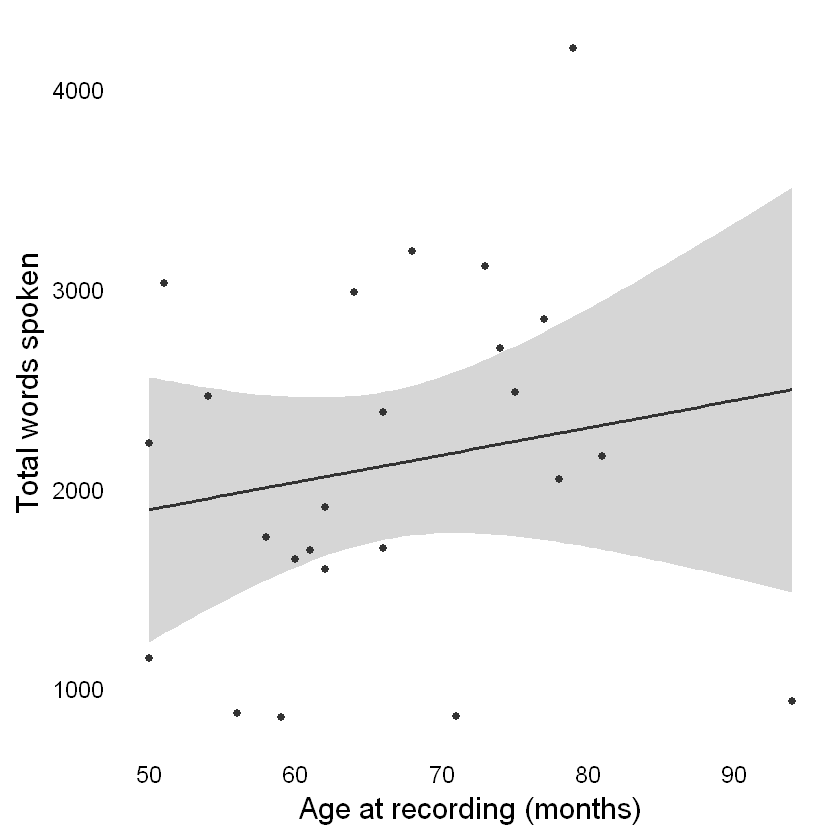

In [62]:
# *total* number of words per child (i.e., not unique words)
# so that we can determine what proportion of the words constitute the top-5
child_word_count_total <- bind_rows(word_list) %>%
  group_by(file_name) %>%
  count(.)

# add age
child_word_count_total <- merge(data_guide_short, child_word_count_total, by='file_name')

cor.test(child_word_count_total$age_at_recording_months, child_word_count_total$n)

# plot against age
ggplot(data = child_word_count_total, aes(x = age_at_recording_months, y = n)) +
  geom_smooth(method = 'lm', se = T, color = 'grey20') +
  geom_point(size = 2, color = 'grey20') + 
  theme_minimal(base_size = 18) +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.text.x=element_text(colour="black"),
        axis.text.y=element_text(colour="black")) +
  xlab('Age at recording (months)') + ylab('Total words spoken')


`geom_smooth()` using formula 'y ~ x'



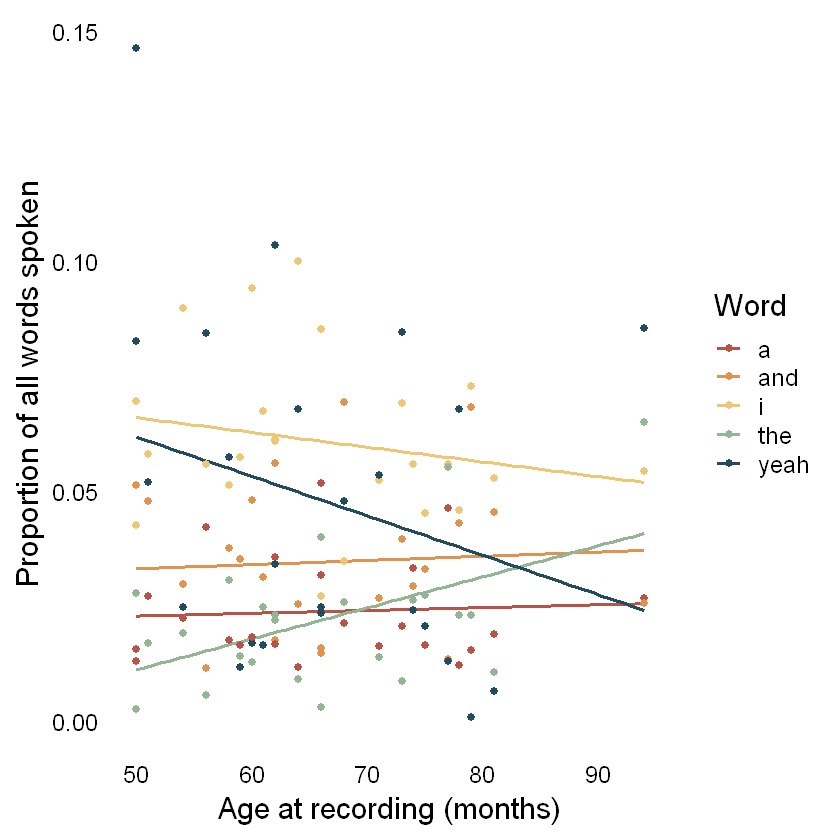

In [69]:
# now calculate the proportion of the total words spoken that consists of each of the top five words
child_word_prop <- merge(top_five_by_child, child_word_count_total, by = 'file_name')
child_word_prop$prop <- child_word_prop$count_child / child_word_prop$n

ggplot(data = child_word_prop, aes(x = age_at_recording_months.x, y = prop, color = Word)) +
  geom_smooth(aes(group = Word, color = Word), method = 'lm', se = F) +
  geom_point(size = 2) + 
  scale_color_manual(values=met.brewer("Hokusai1")[c(2,4:7)]) +
  theme_minimal(base_size = 18) +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.text.x=element_text(colour="black"),
        axis.text.y=element_text(colour="black")) +
  xlab('Age at recording (months)') + ylab('Proportion of all words spoken')


In [73]:
## evaluate relationship between word use proportion & age
aov_time <- aov(prop ~ word + age_at_recording_months.x + word * age_at_recording_months.x
                + Error(file_name/word), data=child_word_prop)
summary(aov_time)

#top_five_by_child
prop_wide <- reshape(child_word_prop, idvar = c("file_name","age_at_recording_months.x","age_at_recording_months.y"), 
                     timevar = "word", direction = "wide")

# correlations
# word: i
cor.test(prop_wide$age_at_recording_months.x, prop_wide$prop.i)

# word: a
cor.test(prop_wide$age_at_recording_months.x, prop_wide$prop.a)

# word: and
cor.test(prop_wide$age_at_recording_months.x, prop_wide$prop.and)

# word: the
cor.test(prop_wide$age_at_recording_months.x, prop_wide$prop.the)

# word: yeah
cor.test(prop_wide$age_at_recording_months.x, prop_wide$prop.yeah)


Error: file_name
                          Df   Sum Sq   Mean Sq F value Pr(>F)
age_at_recording_months.x  1 0.000071 0.0000706   0.213  0.649
Residuals                 22 0.007308 0.0003322               

Error: file_name:word
                               Df  Sum Sq  Mean Sq F value   Pr(>F)    
word                            4 0.02596 0.006491  13.868 8.22e-09 ***
word:age_at_recording_months.x  4 0.00365 0.000911   1.947     0.11    
Residuals                      88 0.04119 0.000468                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


	Pearson's product-moment correlation

data:  prop_wide$age_at_recording_months.x and prop_wide$prop.i
t = -0.95297, df = 22, p-value = 0.351
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5577081  0.2221323
sample estimates:
       cor 
-0.1991058 



	Pearson's product-moment correlation

data:  prop_wide$age_at_recording_months.x and prop_wide$prop.a
t = 0.29099, df = 22, p-value = 0.7738
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3502248  0.4539771
sample estimates:
       cor 
0.06191992 



	Pearson's product-moment correlation

data:  prop_wide$age_at_recording_months.x and prop_wide$prop.and
t = 0.28767, df = 22, p-value = 0.7763
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3508436  0.4534168
sample estimates:
       cor 
0.06121717 



	Pearson's product-moment correlation

data:  prop_wide$age_at_recording_months.x and prop_wide$prop.the
t = 2.7056, df = 22, p-value = 0.01292
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1205656 0.7515700
sample estimates:
     cor 
0.499661 



	Pearson's product-moment correlation

data:  prop_wide$age_at_recording_months.x and prop_wide$prop.yeah
t = -1.2735, df = 22, p-value = 0.2161
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6018116  0.1580789
sample estimates:
       cor 
-0.2620269 


These data suggest that accounting for the total number of words does not meaningfully change the relationship. However, there may be more complex relationships between age, number of months of exposure to English, the number of hours children speak English per day, and other factors which could affect these relationships and could be explored in the future.

### Exploratory analysis: word clouds by age tertile <a name="wordclouds"></a>
Finally, let's carry out an exploratory analysis/visualization. We will split the kids into tertiles according to their ages, and plot the words they tend to use the most in word clouds. 

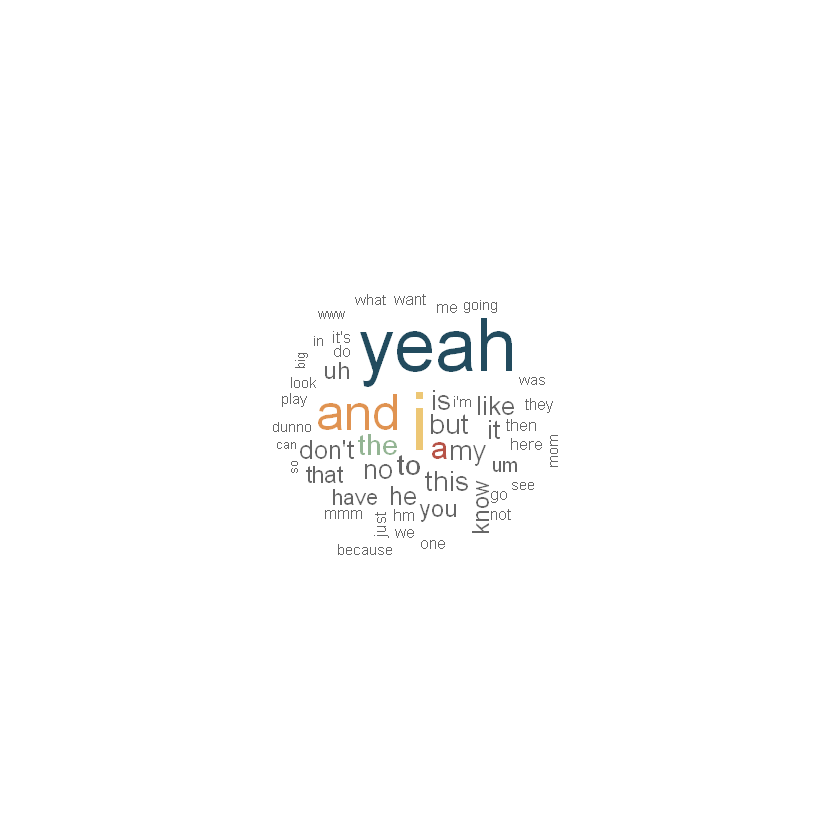

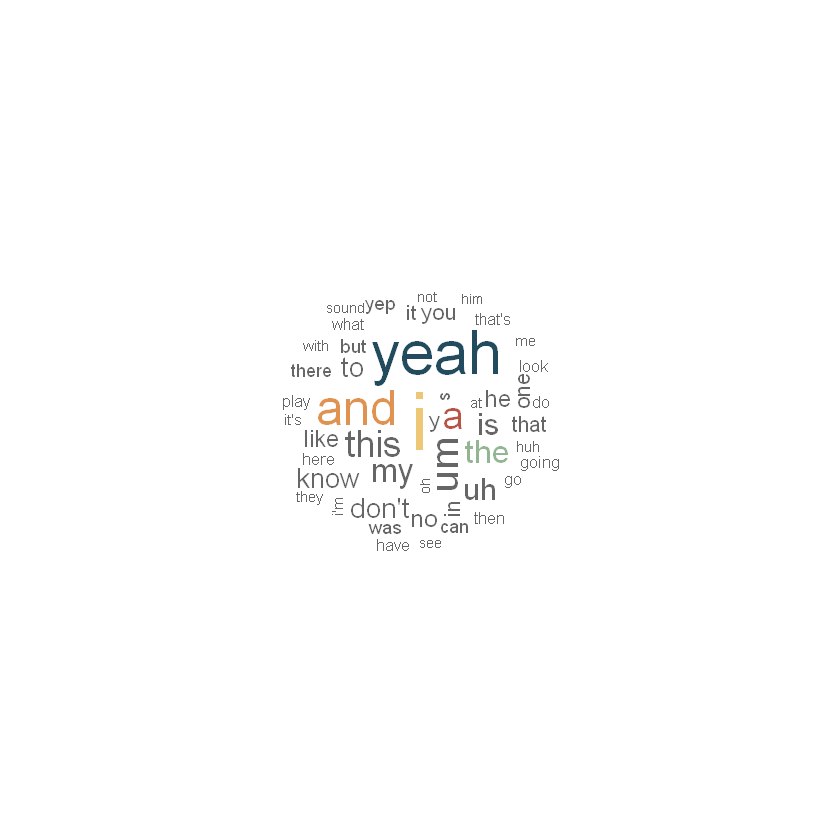

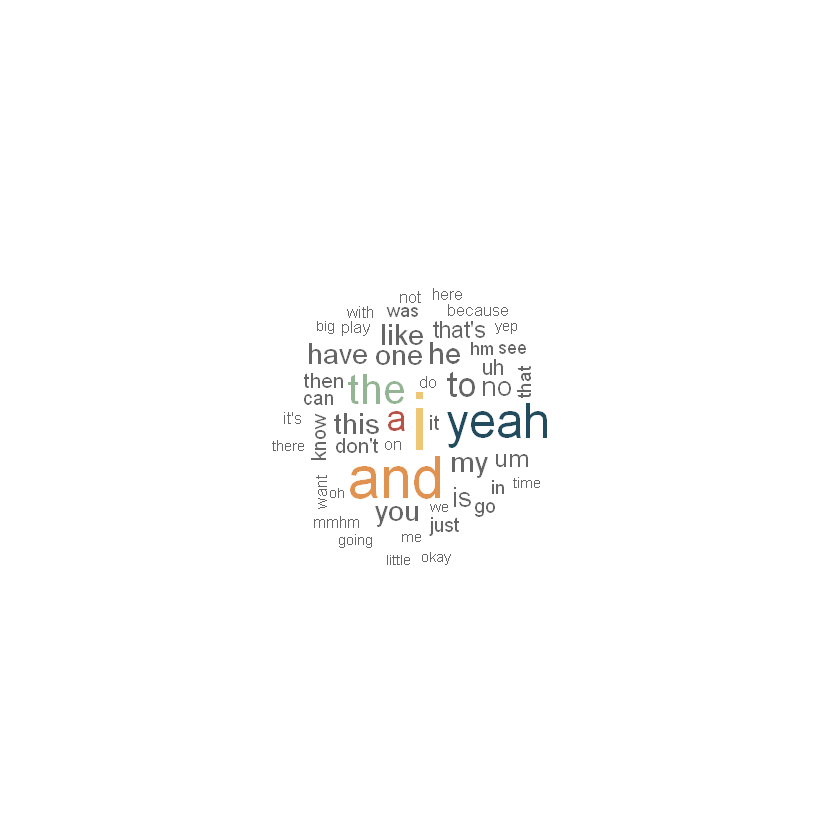

In [78]:
# load wordcloud library
library(wordcloud)

# first, get all data
data_all <- bind_rows(word_list)

# divide data_guide into tertiles according to age
data_guide_short$tertile <- ntile(data_guide_short$age_at_recording_months, 3)  

# combine with *all* words spoken across all children
data_tertiles <- merge(data_all, data_guide_short, by = 'file_name')

# now summarize per tertile
data_tert_sum <- data_tertiles %>%
  group_by(tertile, word) %>%
  count(., sort=T)

mutate(data_tert_sum,
       colors = case_when(word == 'a' ~ "#b75347",
                          word == 'and' ~ "#e09351",
                          word == 'i' ~ "#edc775",
                          word == 'the' ~ "#94b594",
                          word == 'yeah' ~ "#224b5e",
                          TRUE ~ 'grey40')) -> data_tert_sum

# split by tertile (maybe this can be done by facetting but whatever)
tertile_1 <- filter(data_tert_sum, tertile == 1)
tertile_2 <- filter(data_tert_sum, tertile == 2)
tertile_3 <- filter(data_tert_sum, tertile == 3)

wordcloud(words = tertile_1$word, freq = tertile_1$n, colors = tertile_1$colors,
          random.order = FALSE, ordered.colors = TRUE, max.words = 50)

wordcloud(words = tertile_2$word, freq = tertile_2$n, colors = tertile_2$colors,
          random.order = FALSE, ordered.colors = TRUE, max.words = 50)

wordcloud(words = tertile_3$word, freq = tertile_3$n, colors = tertile_3$colors,
          random.order = FALSE, ordered.colors = TRUE, max.words = 50)



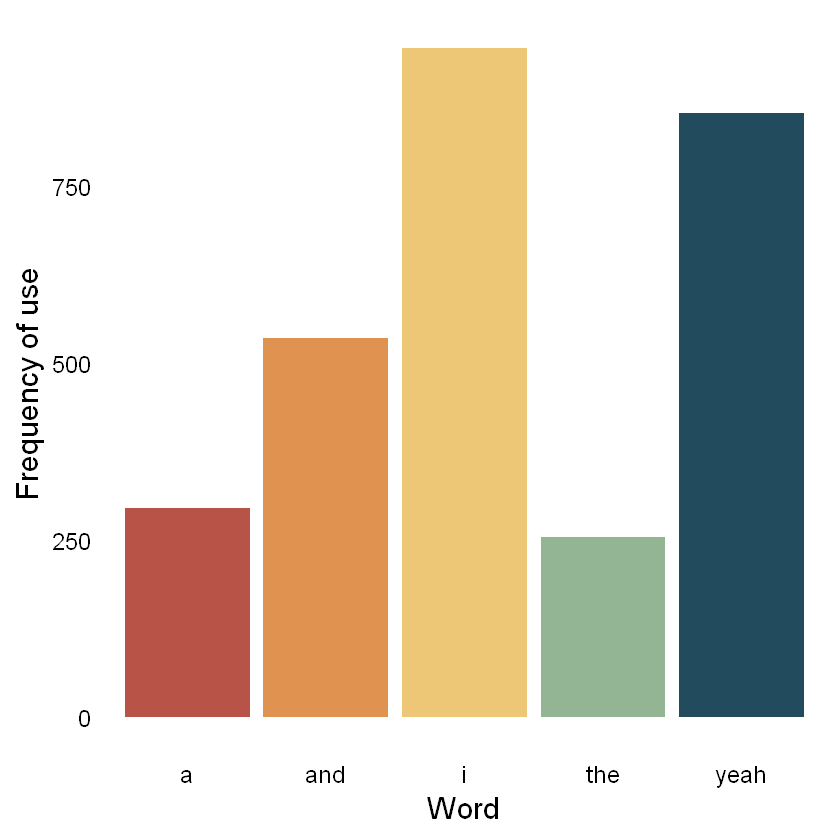

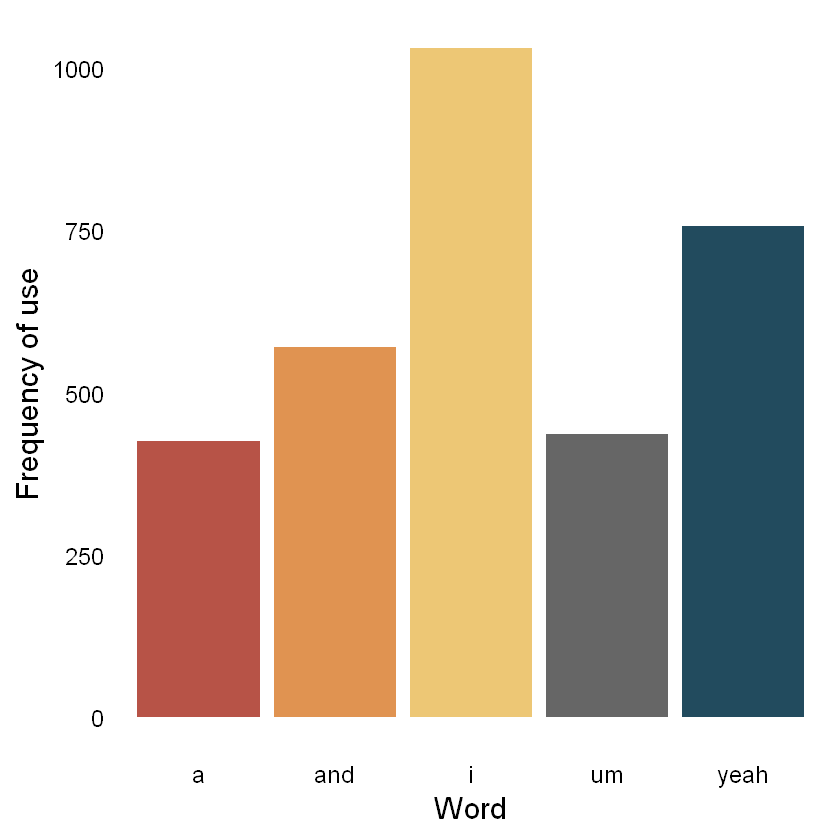

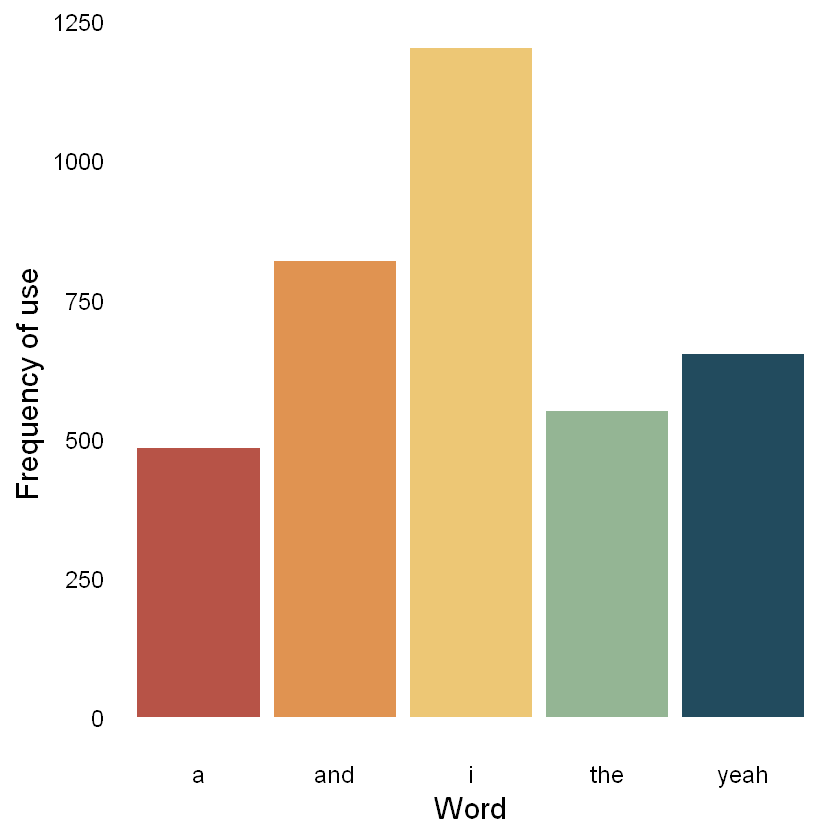

In [124]:
## finally, let's generate bar plots per tertile

tertile_1_5 <- head(tertile_1, 5)
tertile_2_5 <- head(tertile_2, 5)
tertile_3_5 <- head(tertile_3, 5)


MyPalette <- c('a' = "#b75347", 'and' = "#e09351", 'i' = "#edc775", 'the' =  "#94b594", 'yeah' = "#224b5e", 'um' = 'grey40')

ggplot(data = tertile_1_5, aes(x = word, y = n)) + 
  geom_bar(stat= 'identity',aes(fill = word)) +
  scale_fill_manual(values=MyPalette) +
  theme_minimal(base_size = 18) +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.text.x=element_text(colour="black"),
        axis.text.y=element_text(colour="black"),
        legend.position="none") +
  xlab('Word') + ylab('Frequency of use')

ggplot(data = tertile_2_5, aes(x = word, y = n)) + 
  geom_bar(stat= 'identity',aes(fill = word)) +
  scale_fill_manual(values= MyPalette) +
  theme_minimal(base_size = 18) +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.text.x=element_text(colour="black"),
        axis.text.y=element_text(colour="black"),
        legend.position="none") +
  xlab('Word') + ylab('Frequency of use')

ggplot(data = tertile_3_5, aes(x = word, y = n)) + 
  geom_bar(stat= 'identity',aes(fill = word)) +
  scale_fill_manual(values= MyPalette) +
  theme_minimal(base_size = 18) +
  theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.text.x=element_text(colour="black"),
        axis.text.y=element_text(colour="black"),
        legend.position="none") +
  xlab('Word') + ylab('Frequency of use')